<a href="https://colab.research.google.com/github/olszewskip/Sign_Language/blob/master/playground_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ardamavi/Sign-Language-Digits-Dataset

https://www.kaggle.com/datamunge/sign-language-mnist


In [1]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
working_dir = os.path.join("/content/gdrive/My Drive/Colab Notebooks/Sign_Language/")
github_trainval_data = os.path.join(working_dir, "data/ardamavi/Dataset")
github_test_data = os.path.join(working_dir, "data/ardamavi/Dataset_test")
model_checkpoints = os.path.join(working_dir, "models/tmp")
kaggle_dir = os.path.join(working_dir, "data/kaggle/sign-language-mnist")

In [5]:
os.listdir(github_trainval_data)

['6', '7', '5', '0', '8', '4', '1', '2', '3', '9']

In [0]:
# # one-time thing: make a separete directory for test-data
# os.mkdir(github_test_data)

In [7]:
total_count = 0
for class_ in os.listdir(github_trainval_data):
  from_dir = os.path.join(github_trainval_data, class_)
  whole_count = len(os.listdir(from_dir))
  total_count += whole_count
  print(f"class {class_}: {whole_count} photos")

print(f"{total_count} photos in total")

class 6: 188 photos
class 7: 178 photos
class 5: 188 photos
class 0: 180 photos
class 8: 191 photos
class 4: 183 photos
class 1: 180 photos
class 2: 185 photos
class 3: 185 photos
class 9: 180 photos
1838 photos in total


In [0]:
# # one-time thing: set a fraction of the data aside for testing
# test_fraction = 0.1

# for class_ in os.listdir(github_trainval_data):
#   from_dir = os.path.join(github_trainval_data, class_)
#   whole_count = len(os.listdir(from_dir))
#   to_dir = os.path.join(github_test_data, class_)
#   os.mkdir(to_dir)
#   for file in os.listdir(from_dir):
#     if np.random.rand() < test_fraction:
#       from_file = os.path.join(from_dir, file)
#       to_file = os.path.join(to_dir, file)
#       os.rename(from_file, to_file)
#   test_count = len(os.listdir(to_dir))
#   print(f"{class_}: {test_count/whole_count} fraction put aside")

In [0]:
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE_EPOCHS = 20
LR = 0.0004

### Create the data-generators that will:
* handle loading the data from disk (each class from separate sub-directory),
* handle train-validation split (from a single directory of sub-directories),
* resclae RGB values by 1/255,
* alternatively apply data augmentation

In [0]:
def prepare_data_gens(image_dim):

  trainval_gen = ImageDataGenerator(rescale=1/255,
                                    validation_split=0.1/0.8)

  trainval_gen_augment = ImageDataGenerator(rescale=1/255,
                                            validation_split=0.1/0.8,
                                            rotation_range=20,
                                            height_shift_range=0.1,
                                            width_shift_range=0.1,
                                            brightness_range=(0.9, 1.1),
                                            zoom_range=0.1
                                           )

  test_gen = ImageDataGenerator(rescale=1/255)

  train_gen = trainval_gen.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      shuffle=True,
      class_mode='categorical',
      subset='training')

  val_gen = trainval_gen.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical',
      subset='validation')

  train_gen_augment = trainval_gen_augment.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      shuffle=True,
      class_mode='categorical',
      subset='training')

  val_gen_augment = trainval_gen_augment.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical',
      subset='validation')


  test_gen = trainval_gen.flow_from_directory(
      github_test_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical')
  
  return train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen

In [11]:
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(100)

Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 224 images belonging to 10 classes.


In [12]:
train_gen[0][0].shape

(32, 100, 100, 3)

A few random unaugmented images.

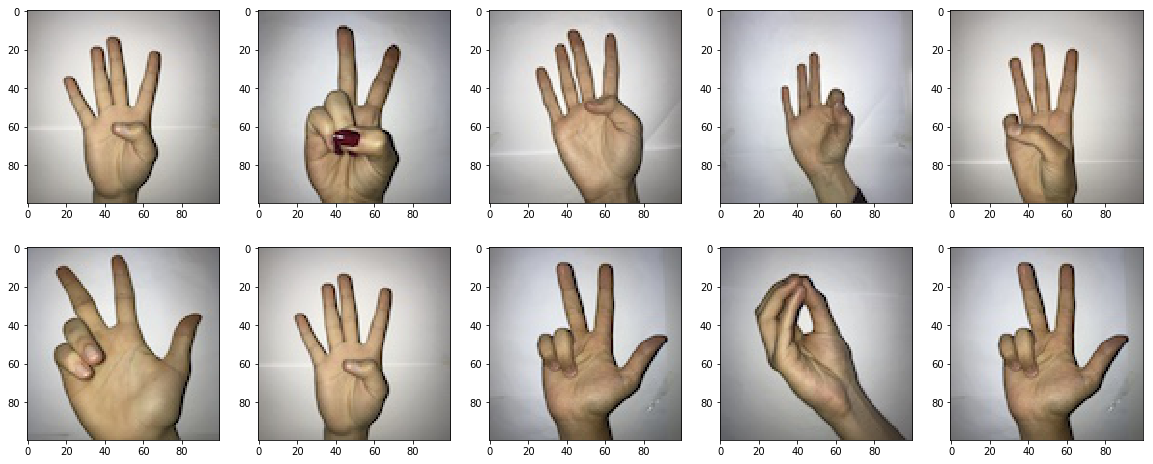

In [13]:
images\
= [train_gen[0][0][np.random.choice(BATCH_SIZE)] for _ in range(10)]
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for img, ax in zip(images, axes.ravel()):
  ax.imshow(img)

A few random augmented images.

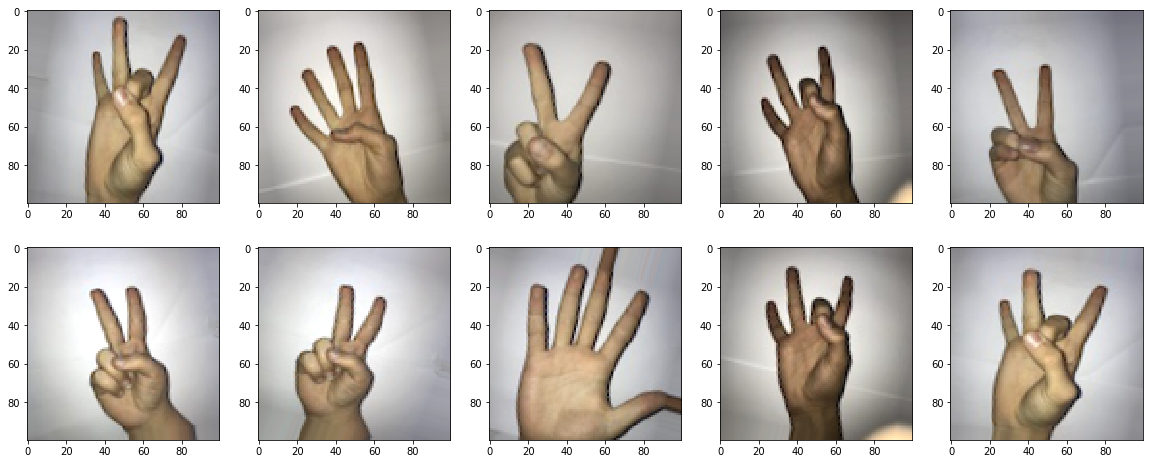

In [14]:
augmented_images\
= [train_gen_augment[0][0][np.random.choice(BATCH_SIZE)] for _ in range(10)]
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for img, ax in zip(augmented_images, axes.ravel()):
  ax.imshow(img)

In [15]:
# Sanity check that all generators see the same number of classes
assert train_gen.num_classes == val_gen.num_classes == train_gen_augment.num_classes == val_gen_augment.num_classes == test_gen.num_classes
num_classes = train_gen.num_classes

# Encoding between directory names and labels
label2class = train_gen.class_indices
label2class

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [0]:
def train_model(model, train_gen, val_gen, weights_file_name, verbosity=1):
  """ Fit the model to training-data-generator.
  Validate on validation-data-generator.
  Save weights of the best model to a file.
  Restore the best weights at the end of training.
  Return history for plotting"""
  
  train_gen.reset()
  val_gen.reset()
  callbacks = [ModelCheckpoint(filepath=os.path.join(model_checkpoints,
                                                     weights_file_name),
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True),
               EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=PATIENCE_EPOCHS,
                             verbose=1,
                             restore_best_weights=True)]

  history = model.fit_generator(
      train_gen,
      steps_per_epoch = int(np.ceil(train_gen.samples / BATCH_SIZE)),
      validation_data = val_gen,
      validation_steps = int(np.ceil(val_gen.samples / BATCH_SIZE)),
      epochs = EPOCHS,
      callbacks = callbacks,
      verbose=verbosity
  )
  return history



def plot_history(history):
  """Plot loss and accuracy on two separete plots."""
  
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(loss))

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, '-', label='Training Accuracy')
  plt.plot(epochs_range, val_acc, '-o', label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, '-', label='Training Loss')
  plt.plot(epochs_range, val_loss, '-o', label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  
  
def count_trainable(model):
  """Utility function"""
  return int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))


# Create a dictionary for aggregating scores obtained with various approaches
model_results = {}
 

---
## Simple sequential model

The number of trainable parameters is about 2 mil.

In [17]:
image_dim = 100
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(image_dim)

Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 224 images belonging to 10 classes.


In [0]:
def simple_seq(img_dim):
  
  activ = 'elu'
  inputs = Input(shape = (img_dim, img_dim, 3))
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=activ)(inputs)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  outputs = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=inputs, outputs=outputs)
  return model

### No data augmentation (simple seq.)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Trainable params: 2467946
Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 1.65832, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00002: val_loss improved from 1.65832 to 1.57959, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00003: val_loss improved from 1.57959 to 1.55979, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00004: val_loss improved from 1.55979 to 1.47547, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00005: val_loss did not improve from 1.47547

Epoch 00006: val_loss did not improve from 1.4

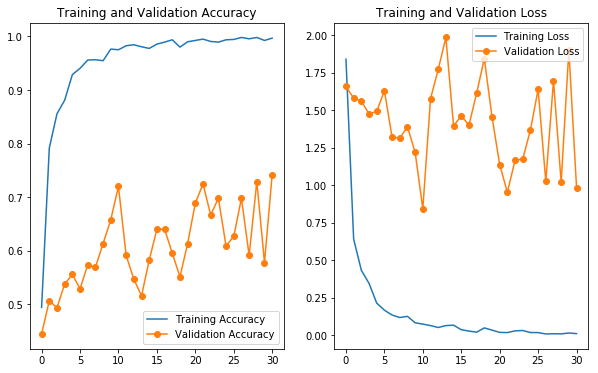

['loss', 'acc']
[0.3146251652921949, 0.9285714285714286]


In [19]:
desc = "simple_seq"

model1 = simple_seq(image_dim)

print("Trainable params:", count_trainable(model1))

model1.compile(loss = 'categorical_crossentropy',
               metrics=['accuracy'],
               optimizer = Adam(lr=LR))

history1 = train_model(model1,
                       train_gen,
                       val_gen,
                       f"{desc}_weights.h5",
                       0)

plot_history(history1)

val_gen.reset()

print(model1.metrics_names)

# model1.evaluate_generator(val_gen,
#                           steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
# ,\
result=\
model1.evaluate_generator(test_gen,
                          steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
model_results[1] = (desc, result)
print(result)

### With data augmentation (simple seq.)

*Note: The validation data is also augmented.*

Trainable params: 2467946

Epoch 00001: val_loss improved from inf to 1.97753, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_with_augm_weights.h5

Epoch 00002: val_loss improved from 1.97753 to 1.95667, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_with_augm_weights.h5

Epoch 00003: val_loss improved from 1.95667 to 1.92594, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_with_augm_weights.h5

Epoch 00004: val_loss improved from 1.92594 to 1.88332, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_with_augm_weights.h5

Epoch 00005: val_loss improved from 1.88332 to 1.26755, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_with_augm_weights.h5

Epoch 00006: val_loss improved from 1.26755 to 1.12554, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Lang

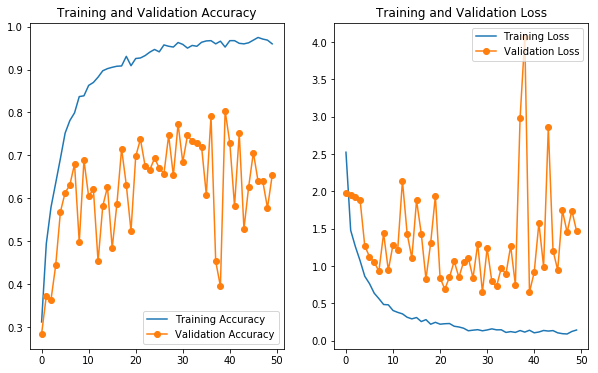

['loss', 'acc']
[0.21578780189156532, 0.9419642857142857]


In [20]:
desc = "simple_seq_with_augm"

model2 = simple_seq(image_dim)

print("Trainable params:", count_trainable(model2))

model2.compile(loss = 'categorical_crossentropy',
               metrics=['accuracy'],
               optimizer = Adam(lr=LR))

history2 = train_model(model2,
                       train_gen_augment,
                       val_gen_augment,
                       f"{desc}_weights.h5",
                       0)

plot_history(history2)

val_gen_augment.reset()

print(model2.metrics_names)

# model2.evaluate_generator(val_gen_augment,
#                           steps = int(np.ceil(val_gen_augment.samples / BATCH_SIZE)))\
# ,\

result\
= model2.evaluate_generator(test_gen,
                            steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
model_results[2] = (desc, result)
print(result)

---
## MobileNet_V2 - feature-extractor
Rather that coming up with out own architecture, let's use one that was developed by someone else: here we choose the MobileNet V2.
Check the performance both with and without retraining (some of) the weights (originally trainded on *image-net*).

In [0]:
def mobile_net_v2(img_dim, retrain_fraction):
  
  MobileNetV2_ = MobileNetV2(include_top=False,
                             weights='imagenet',
                             input_shape=(img_dim, img_dim, 3))
  layer_count = len(MobileNetV2_.layers)
  for idx in range(int(layer_count * (1 - retrain_fraction))):
    MobileNetV2_.layers[idx].trainable = False

      
  x = MobileNetV2_.output
  x = GlobalMaxPooling2D()(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  output = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=MobileNetV2_.input, outputs=output)
  return model

In [22]:
image_dim = 128
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(image_dim)

Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 224 images belonging to 10 classes.


### No data augmentation, no mobilenet retraining

Trainable params: 661002

Epoch 00001: val_loss improved from inf to 2.34678, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00002: val_loss improved from 2.34678 to 2.09062, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00003: val_loss improved from 2.09062 to 1.95802, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00004: val_loss improved from 1.95802 to 1.88435, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00005: val_loss did not improve from 1.88435

Epoch 00006: val_loss improved from 1.88435 to 1.74440, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00007: val_loss did not improve from 1.74440

Epoch 00008: val_loss did not improve from 1.74440

Epoch 00009:

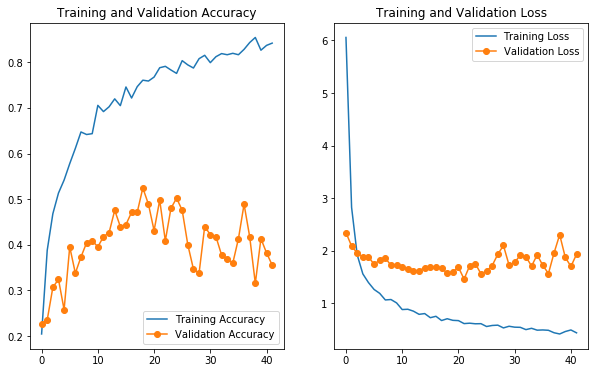

['loss', 'acc']
[1.6021254573549544, 0.41964285714285715]


In [23]:
desc = "mobilenetv2"

model3 = mobile_net_v2(image_dim, retrain_fraction=0)

print("Trainable params:", count_trainable(model3))

model3.compile(optimizer=Adam(lr=LR),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history3 = train_model(model3,
                       train_gen,
                       val_gen,
                       f"{desc}_weights.h5",
                       0)

plot_history(history3)

print(model3.metrics_names)

# model3.evaluate_generator(val_gen,
#                           steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
# ,\
result\
= model3.evaluate_generator(test_gen,
                            steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
model_results[3] = (desc, result)
print(result)

### With data augmentation, no mobilenet retraining

*Note: The validation data is also augmented.*

Trainable params: 661002

Epoch 00001: val_loss improved from inf to 2.30442, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00002: val_loss improved from 2.30442 to 2.14928, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00003: val_loss improved from 2.14928 to 1.93219, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00004: val_loss improved from 1.93219 to 1.87135, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00005: val_loss improved from 1.87135 to 1.82712, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00006: val_loss improved from 1.82712 to 1.79742, saving model to /content/gdrive/My Drive/Colab 

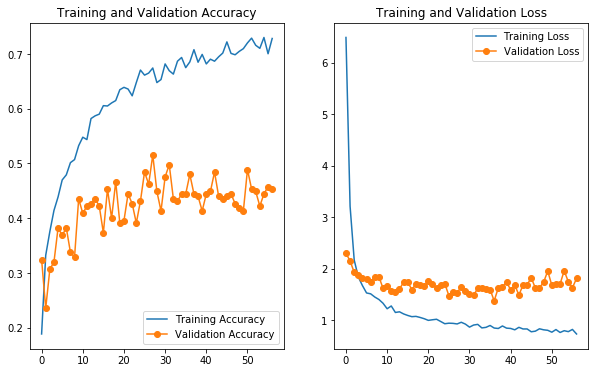

['loss', 'acc']
[1.2160813893590654, 0.5446428571428571]


In [24]:
desc = "mobilenetv2_with_augment"

model4 = mobile_net_v2(image_dim, retrain_fraction=0)

print("Trainable params:", count_trainable(model4))

model4.compile(optimizer=Adam(lr=LR),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history4 = train_model(model4,
                       train_gen_augment,
                       val_gen_augment,
                       f"{desc}_weights.h5",
                       0)

plot_history(history4)

print(model4.metrics_names)

# model4.evaluate_generator(val_gen_augment,
#                           steps = int(np.ceil(val_gen_augment.samples / BATCH_SIZE)))\
# ,\
result\
= model4.evaluate_generator(test_gen,
                            steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
model_results[4] = (desc, result)
print(result)

### Without data augmentation,  part of mobilenet retrained

Trainable params: 2880458
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Epoch 00001: val_loss improved from inf to 4.05577, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_weights.h5

Epoch 00002: val_loss improved from 4.05577 to 3.77324, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_weights.h5

Epoch 00003: val_loss improved from 3.77324 to 3.50412, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_weights.h5

Epoch 00004: val_loss improved from 3.50412 to 2.71613, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_weights.h5

Epoch 00005: val_loss improved from 2.71613 to 2.53259, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_weights.h5

Epoch 00006: val_loss improved from 2.53259 to 2.

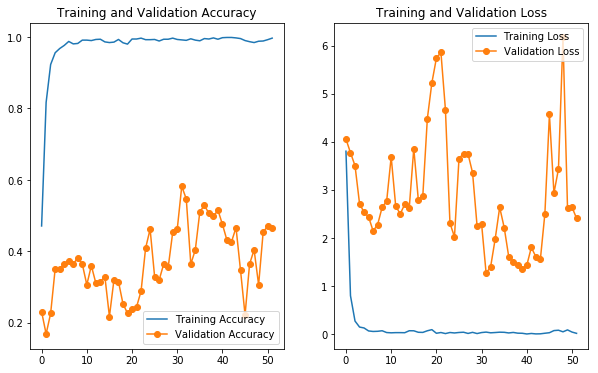

['loss', 'acc']
[0.3574391944067819, 0.875]


In [25]:
desc = "mobilenetv2_retrain"

model5 = mobile_net_v2(image_dim, retrain_fraction=0.9)

model5.compile(optimizer=Adam(lr=LR),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

print("Trainable params:", count_trainable(model5))

history5 = train_model(model5,
                       train_gen,
                       val_gen,
                       f"{desc}_weights.h5",
                       0)

plot_history(history5)

print(model5.metrics_names)

# model5.evaluate_generator(val_gen,
#                           steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
# ,\
result\
= model5.evaluate_generator(test_gen, 
                            steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))

model_results[5] = (desc, result)
print(result)

### With data augmentation, part of mobilenet-retraining

*Note: The validation data is also augmented.*

Trainable params: 2880458

Epoch 00001: val_loss improved from inf to 3.68232, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_weights.h5

Epoch 00002: val_loss improved from 3.68232 to 3.17693, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_weights.h5

Epoch 00003: val_loss improved from 3.17693 to 2.73368, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_weights.h5

Epoch 00004: val_loss improved from 2.73368 to 2.29102, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_weights.h5

Epoch 00005: val_loss did not improve from 2.29102

Epoch 00006: val_loss did not improve from 2.29102

Epoch 00007: val_loss did not improve from 2.29102

Epoch 00008: val_loss did not improve from 2.29102

Epoch 00009: val_loss did not improve

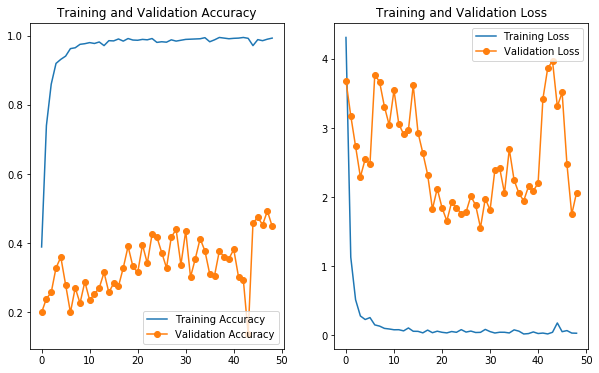

['loss', 'acc']
[0.9161586080278669, 0.78125]


In [26]:
desc = "mobilenetv2_with_augment_retrain"

model6 = mobile_net_v2(image_dim, retrain_fraction=0.9)

print("Trainable params:", count_trainable(model6))

model6.compile(optimizer=Adam(lr=LR),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


history6 = train_model(model6,
                       train_gen_augment,
                       val_gen_augment,
                       f"{desc}_weights.h5",
                       0)

plot_history(history6)

print(model6.metrics_names)

# model6.evaluate_generator(val_gen_augment,
#                           steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
# ,\
result\
= model6.evaluate_generator(test_gen,
                            steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
model_results[6] = (desc, result)
print(result)

### Without data augmentation,  the whole of mobilenet retrained

Trainable params: 2884874

Epoch 00001: val_loss improved from inf to 1.78491, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_whole_weights.h5

Epoch 00002: val_loss improved from 1.78491 to 1.16411, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_whole_weights.h5

Epoch 00003: val_loss improved from 1.16411 to 0.83882, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_whole_weights.h5

Epoch 00004: val_loss improved from 0.83882 to 0.43200, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_retrain_whole_weights.h5

Epoch 00005: val_loss did not improve from 0.43200

Epoch 00006: val_loss did not improve from 0.43200

Epoch 00007: val_loss did not improve from 0.43200

Epoch 00008: val_loss did not improve from 0.43200

Epoch 00009: val_loss did not improve from 0.43200

Epoch 00010: 

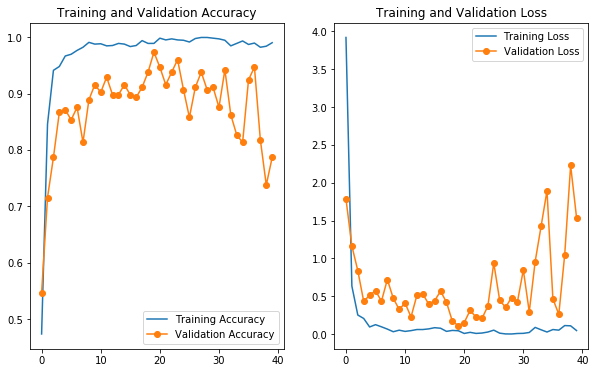

['loss', 'acc']
[0.07368274511281925, 0.9955357142857143]


In [27]:
desc = "mobilenetv2_retrain_whole"

model7 = mobile_net_v2(image_dim, retrain_fraction=1)

model7.compile(optimizer=Adam(lr=LR),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

print("Trainable params:", count_trainable(model7))

history7 = train_model(model7,
                       train_gen,
                       val_gen,
                       f"{desc}_weights.h5",
                       0)

plot_history(history7)

print(model7.metrics_names)

# model7.evaluate_generator(val_gen,
#                           steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
# ,\
result\
= model7.evaluate_generator(test_gen,
                            steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
model_results[7] = (desc, result)
print(result)

### With data augmentation, the whole of mobilenet retrained

*Note: The validation data is also augmented.*

Trainable params: 661002

Epoch 00001: val_loss improved from inf to 2.65465, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_whole_weights.h5

Epoch 00002: val_loss improved from 2.65465 to 2.00519, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_whole_weights.h5

Epoch 00003: val_loss improved from 2.00519 to 1.87977, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_whole_weights.h5

Epoch 00004: val_loss improved from 1.87977 to 1.85510, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_whole_weights.h5

Epoch 00005: val_loss improved from 1.85510 to 1.78877, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_retrain_whole_weights.h5

Epoch 00006: val_loss did not imp

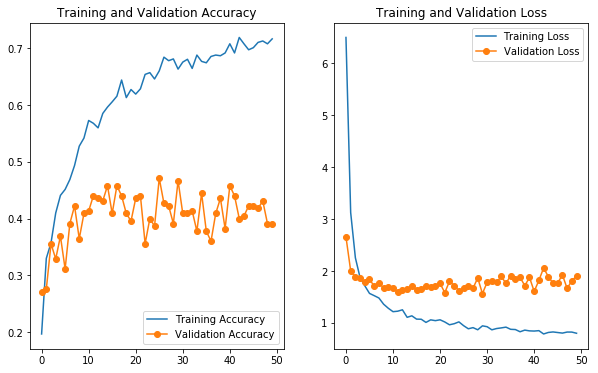

['loss', 'acc']
[1.336249828338623, 0.5267857142857143]


In [28]:
desc = "mobilenetv2_with_augment_retrain_whole"

model8 = mobile_net_v2(image_dim, retrain_fraction=0)

print("Trainable params:", count_trainable(model8))

model8.compile(optimizer=Adam(lr=LR),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


history8 = train_model(model8,
                       train_gen_augment,
                       val_gen_augment,
                       f"{desc}_weights.h5",
                       0)

plot_history(history8)

print(model8.metrics_names)

# model8.evaluate_generator(val_gen_augment,
#                           steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
# ,\
result\
= model8.evaluate_generator(test_gen,
                            steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
model_results[8] = (desc, result)
print(result)

## Summary

In [0]:
import pandas as pd

In [0]:
final_results\
=\
pd.DataFrame(\
 np.array([[desc, loss, acc] for (key, (desc, (loss, acc))) in model_results.items()]).reshape(-1, 3),\
 columns = ['desc', 'loss', 'acc'], index = model_results.keys()
)

In [33]:
final_results

,desc,loss,acc
1,simple_seq,0.3146251652921949,0.9285714285714286
2,simple_seq_with_augm,0.21578780189156532,0.9419642857142857
3,mobilenetv2,1.6021254573549544,0.41964285714285715
4,mobilenetv2_with_augment,1.2160813893590654,0.5446428571428571
5,mobilenetv2_retrain,0.3574391944067819,0.875
6,mobilenetv2_with_augment_retrain,0.9161586080278669,0.78125
7,mobilenetv2_retrain_whole,0.07368274511281925,0.9955357142857143
8,mobilenetv2_with_augment_retrain_whole,1.336249828338623,0.5267857142857143
